# TELECOM CUSTOMER CHURN PREDICTION

Группа 1: Уначева Амина, Алексеева Екатерина, Казакова Светлана, Нежурина Екатерина, Золотухина Евгения, Кудабаева Гульшат

Ссылка на данные: https://www.kaggle.com/datasets/suraj520/telecom-churn-dataset

Ссылка на источник со статьей: https://ieeexplore.ieee.org/document/10574660  

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_score, recall_score, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import ADASYN, SMOTE
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from matplotlib.colors import LinearSegmentedColormap
import random

Переменные

customer_id:  Уникальный идентификатор для каждого клиента.

telecom_partner: Телекоммуникационный партнер, связанный с клиентом.

gender: Пол клиента.

age: Возраст клиента.

state: Индийский штат, в котором находится клиент.

city: Город, в котором находится клиент.

pincode: Идентификационный код местоположения клиента.

date_of_registration: Дата, в которую клиент зарегистрировался у телекоммуникационного партнера.

num_dependents: Количество иждивенцев (например, детей), находящихся на иждивении клиента.

estimated_salary: Оцененная зарплата клиента.

calls_made: Количество звонков, совершенных клиентом.

sms_sent: Количество SMS-сообщений, отправленных клиентом.

data_used: Объем данных, используемых клиентом.

churn: двоичная переменная, указывающая, уход клиента (1 = отток, 0 = нет).

# Предобработка и визуализация

In [ ]:
# 1. Загрузка данных
data = pd.read_csv('telecom_churn.csv')
data.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,date_of_registration,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,1,Reliance Jio,F,25,Karnataka,Kolkata,755597,2020-01-01,4,124962,44,45,-361,0
1,2,Reliance Jio,F,55,Mizoram,Mumbai,125926,2020-01-01,2,130556,62,39,5973,0
2,3,Vodafone,F,57,Arunachal Pradesh,Delhi,423976,2020-01-01,0,148828,49,24,193,1
3,4,BSNL,M,46,Tamil Nadu,Kolkata,522841,2020-01-01,1,38722,80,25,9377,1
4,5,BSNL,F,26,Tripura,Delhi,740247,2020-01-01,2,55098,78,15,1393,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243553 entries, 0 to 243552
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   customer_id           243553 non-null  int64 
 1   telecom_partner       243553 non-null  object
 2   gender                243553 non-null  object
 3   age                   243553 non-null  int64 
 4   state                 243553 non-null  object
 5   city                  243553 non-null  object
 6   pincode               243553 non-null  int64 
 7   date_of_registration  243553 non-null  object
 8   num_dependents        243553 non-null  int64 
 9   estimated_salary      243553 non-null  int64 
 10  calls_made            243553 non-null  int64 
 11  sms_sent              243553 non-null  int64 
 12  data_used             243553 non-null  int64 
 13  churn                 243553 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 26.0+ MB


In [ ]:
data.isnull().sum()

customer_id             0
telecom_partner         0
gender                  0
age                     0
state                   0
city                    0
pincode                 0
date_of_registration    0
num_dependents          0
estimated_salary        0
calls_made              0
sms_sent                0
data_used               0
churn                   0
dtype: int64

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.describe()

,customer_id,age,pincode,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
count,243553.000000,243553.000000,243553.000000,243553.000000,243553.000000,243553.000000,243553.000000,243553.000000,243553.000000
mean,121777.000000,46.077609,549501.270541,1.997500,85021.137839,49.010548,23.945404,4993.186025,0.200478
std,70307.839393,16.444029,259808.860574,1.414941,37508.963233,29.453556,14.733575,2942.019547,0.400359
min,1.000000,18.000000,100006.000000,0.000000,20000.000000,-10.000000,-5.000000,-987.000000,0.000000
25%,60889.000000,32.000000,324586.000000,1.000000,52585.000000,24.000000,11.000000,2490.000000,0.000000
50%,121777.000000,46.000000,548112.000000,2.000000,84990.000000,49.000000,24.000000,4987.000000,0.000000
75%,182665.000000,60.000000,774994.000000,3.000000,117488.000000,74.000000,36.000000,7493.000000,0.000000
max,243553.000000,74.000000,999987.000000,4.000000,149999.000000,108.000000,53.000000,10991.000000,1.000000


In [ ]:
numeric_df = data.select_dtypes(include='number')

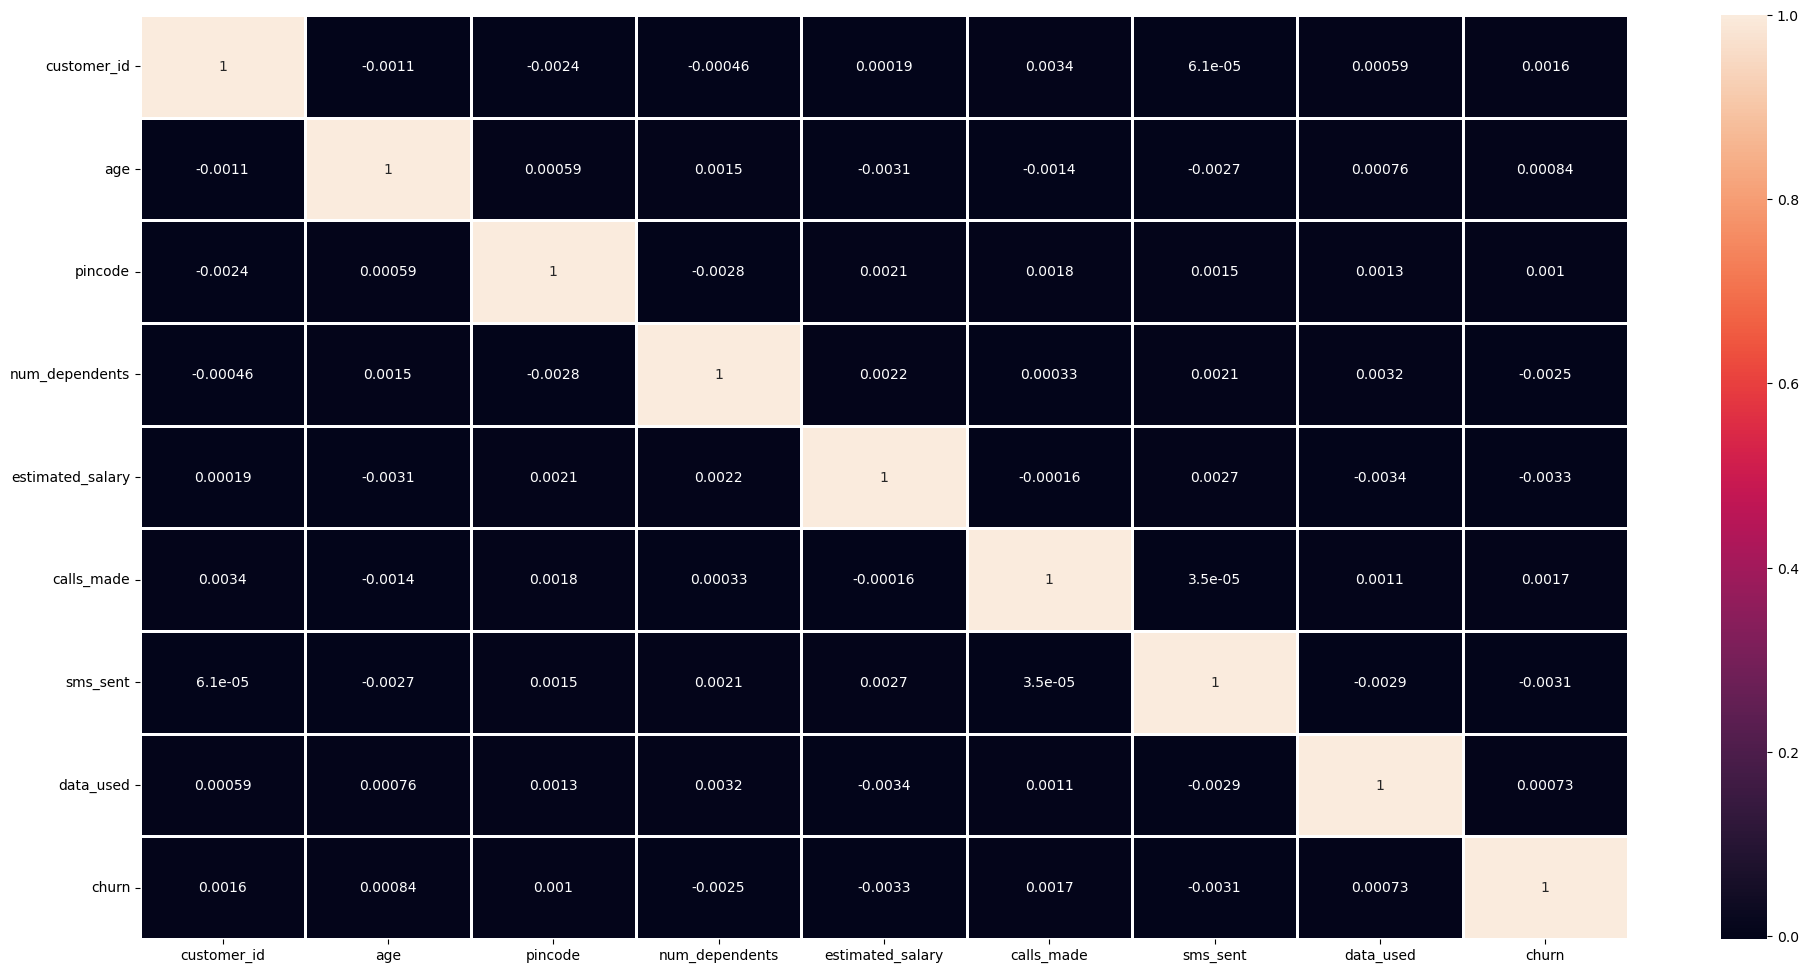

In [ ]:
plt.figure(figsize = (24, 12))

corr = numeric_df.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

In [ ]:
data['churn'].value_counts()

churn
0    194726
1     48827
Name: count, dtype: int64

Построим гистограммы для переменных:

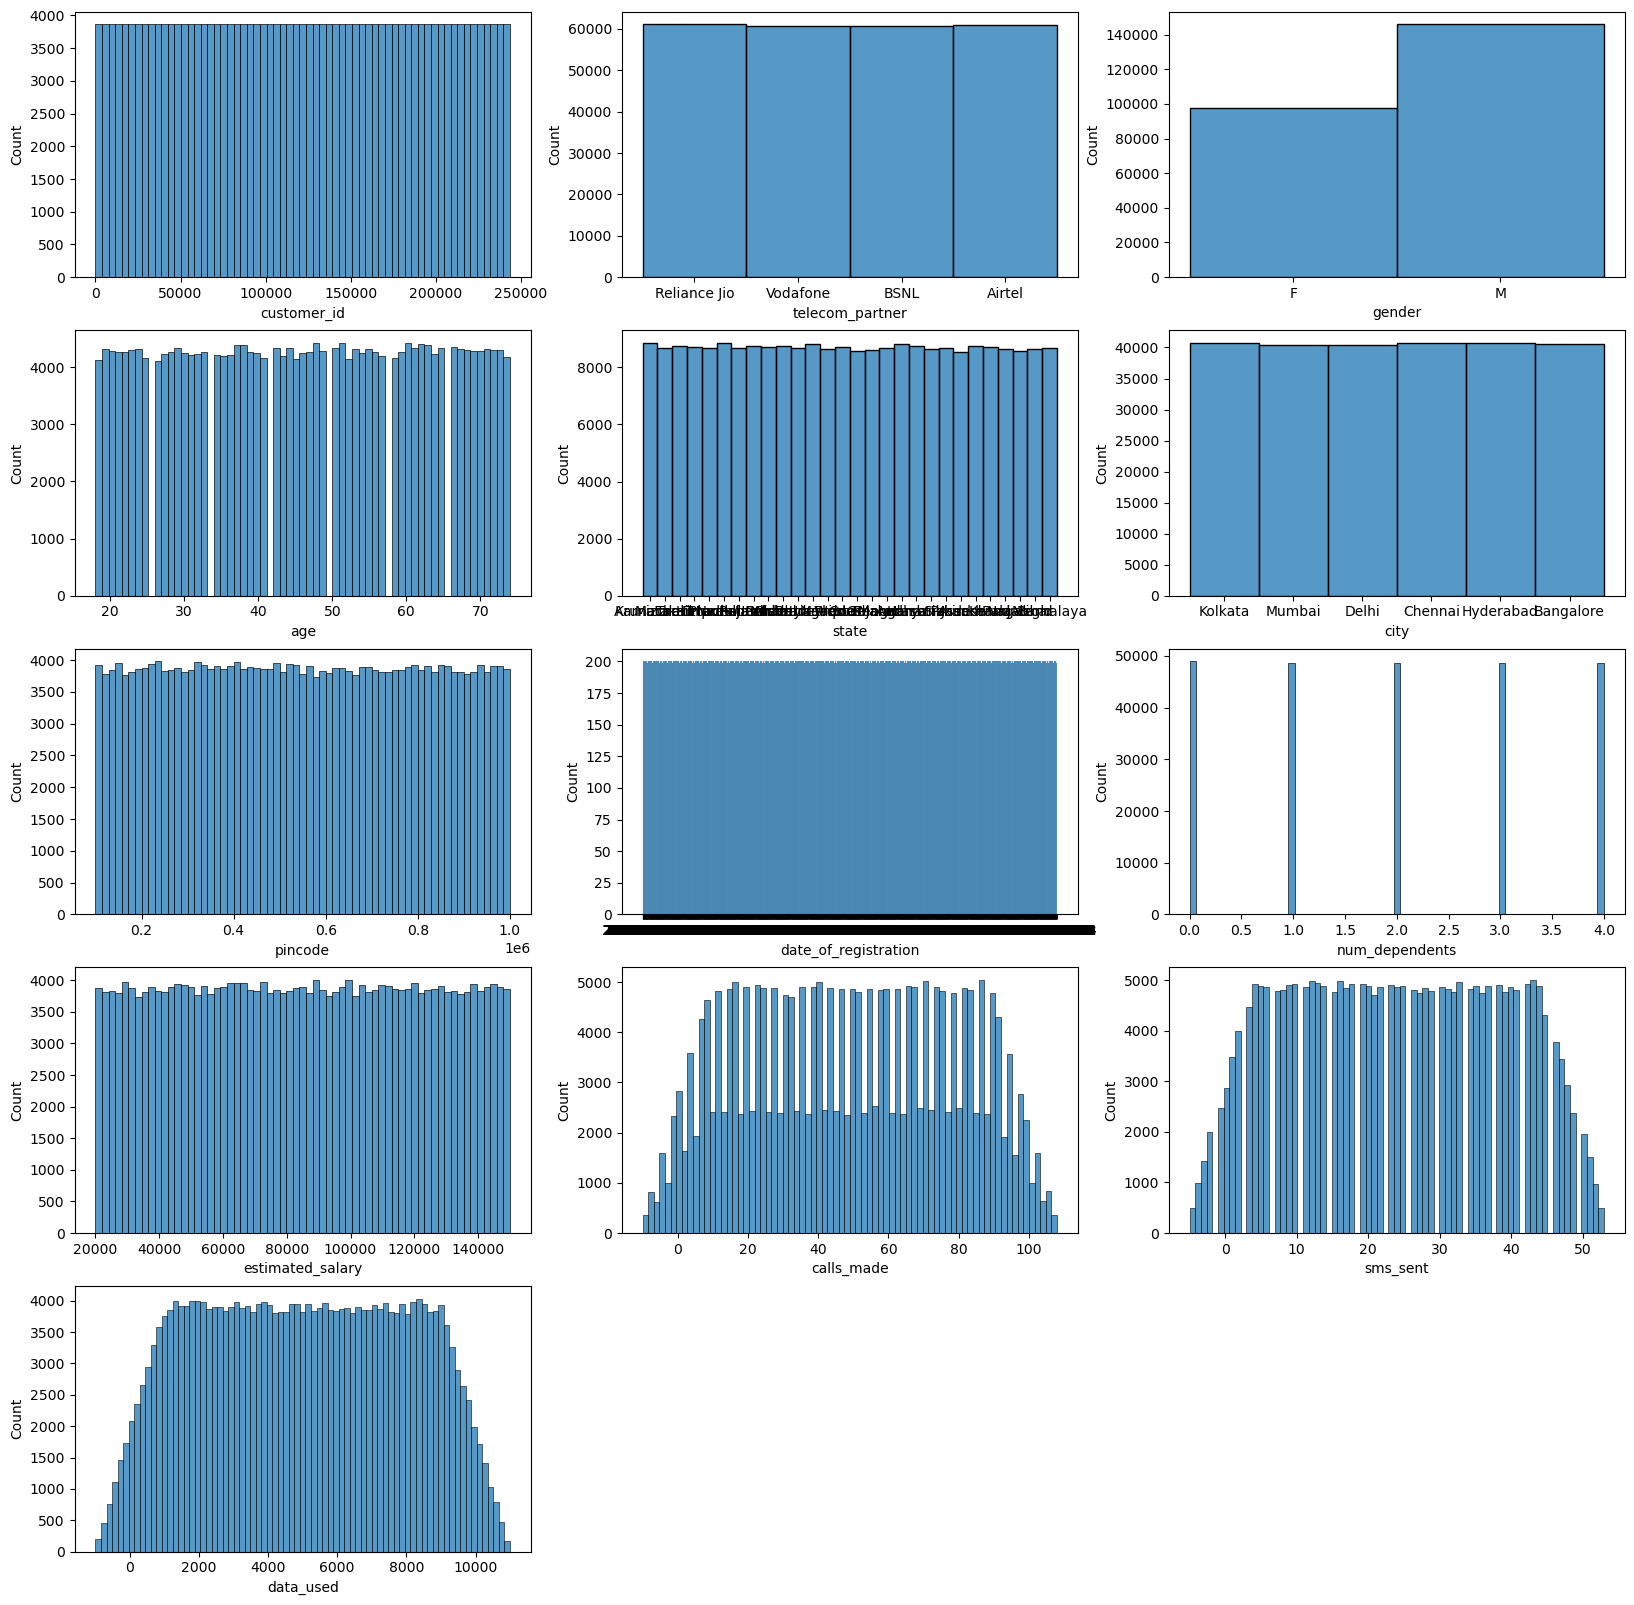

In [ ]:
plt.figure(figsize=(20,20))
i=1
for col in data.columns[:-1]:
    plt.subplot(5,3,i)
    sns.histplot(data[col])
    i=i+1

Данные в целом сбалансированы по операторам, штатам, городам, но вот мужчин в выборке больше, чем женщин.

In [ ]:
churn_data=data[data['churn']==1]['telecom_partner']
non_churn_data=data[data['churn']==0]['telecom_partner']
churn_data

2             Vodafone
3                 BSNL
7                 BSNL
10              Airtel
16            Vodafone
              ...     
243523    Reliance Jio
243527            BSNL
243529    Reliance Jio
243533    Reliance Jio
243535            BSNL
Name: telecom_partner, Length: 48827, dtype: object

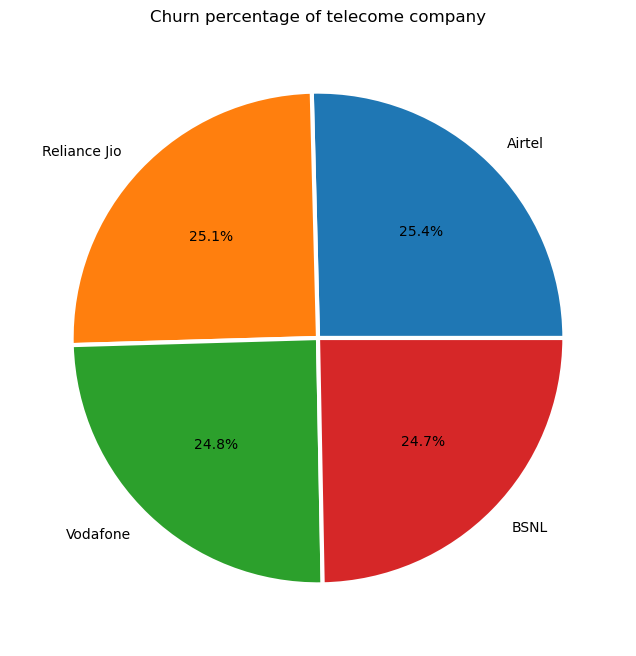

In [ ]:
plt.figure(figsize=(10,8))
company_churn_values=list(churn_data.value_counts())
plt.pie(company_churn_values,labels=churn_data.value_counts().keys(),
      autopct='%.1f%%',wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.title("Churn percentage of telecome company")
plt.show()

Видим, что операторы распределены равномерно среди тех, кто решил уйти от оператора.

In [ ]:
churn_data_gender=data[data['churn']==1]['gender']
non_churn_data_gender=data[data['churn']==0]['gender']

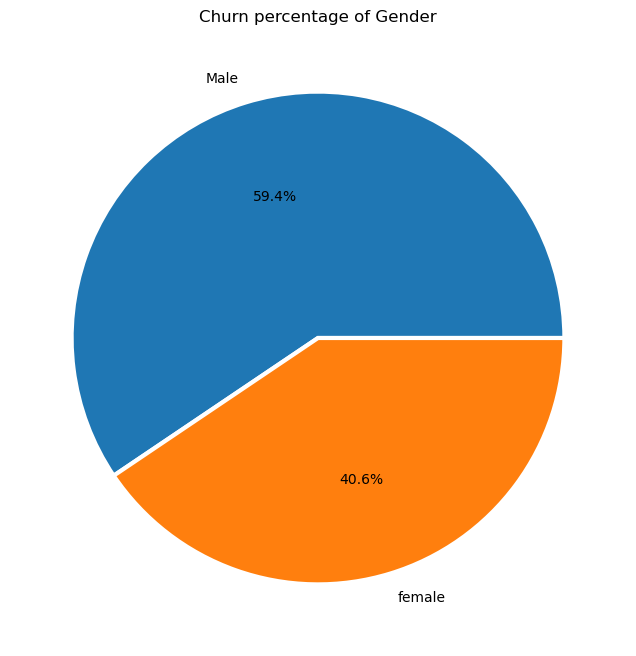

In [ ]:
plt.figure(figsize=(10,8))
plt.pie(churn_data_gender.value_counts(),autopct='%.1f%%',labels=['Male',"female"],wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
plt.title("Churn percentage of Gender")
plt.show()

Среди ушедших от операторов больше мужчин, чем женщин, но это может быть связано с изначальной диспропорцией данных по этому признаку.

In [ ]:
churn_age=data[data['churn']==1]['age']
age=data[data['churn']==0]['age']

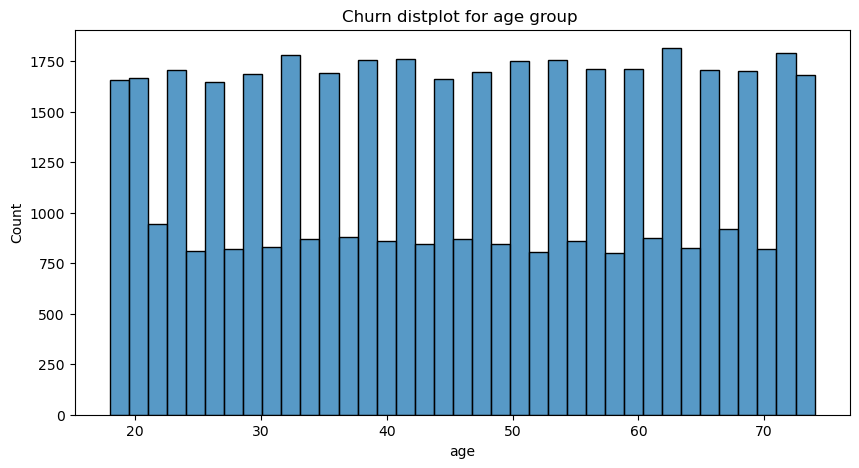

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(churn_age)
plt.title("Churn distplot for age group ")
plt.show()

Люди в возрасте 19-20 лет и после 70 чаще уходят от телекоммуникационной компании.

In [ ]:
churn_salary=data[data['churn']==1]['estimated_salary']
nonchurn_salary=data[data['churn']==0]['estimated_salary']

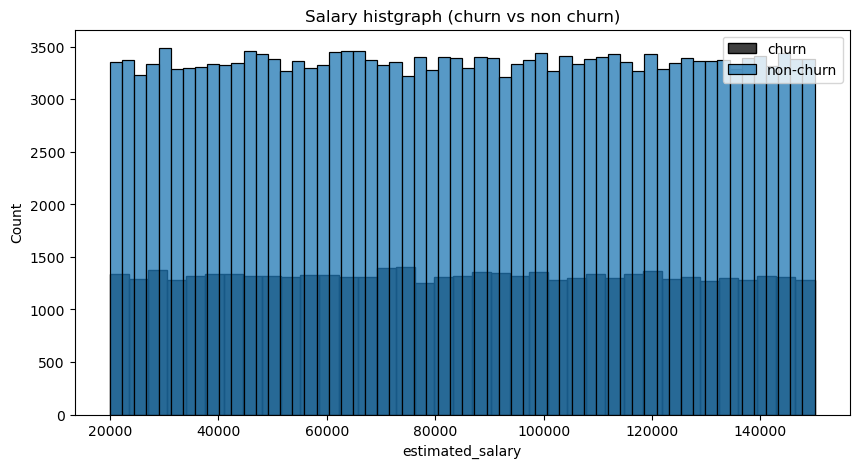

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(churn_salary,label="churn",color="black")
sns.histplot(nonchurn_salary,label="non-churn")
plt.title("Salary histgraph (churn vs non churn)")
plt.legend()
plt.show()

Люди, которые уходят от оператора имеют меньшую зарплату, чем те, кто остается.

In [ ]:
churn_calls=data[data['churn']==1]['calls_made']
nonchurn_calls=data[data['churn']==0]['calls_made']

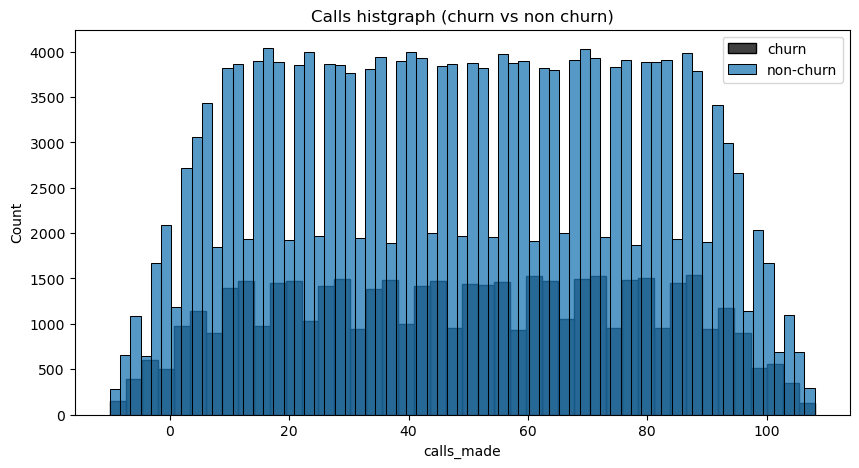

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(churn_calls,label="churn",color="black")
sns.histplot(nonchurn_calls,label="non-churn")
plt.title("Calls histgraph (churn vs non churn)")
plt.legend()
plt.show()

In [ ]:
churn_sms=data[data['churn']==1]['sms_sent']
nonchurn_sms=data[data['churn']==0]['sms_sent']

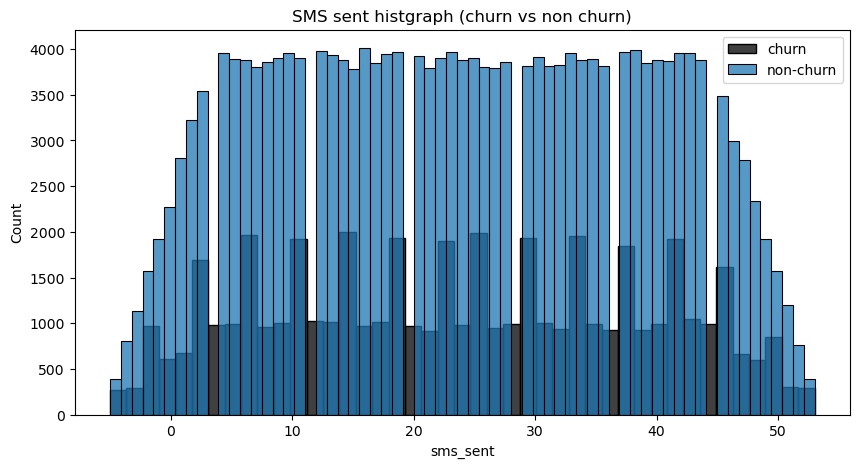

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(churn_sms,label="churn",color="black")
sns.histplot(nonchurn_sms,label="non-churn")
plt.title("SMS sent histgraph (churn vs non churn)")
plt.legend()
plt.show()

In [ ]:
churn_data_used=data[data['churn']==1]['data_used']
nonchurn_data_used=data[data['churn']==0]['data_used']

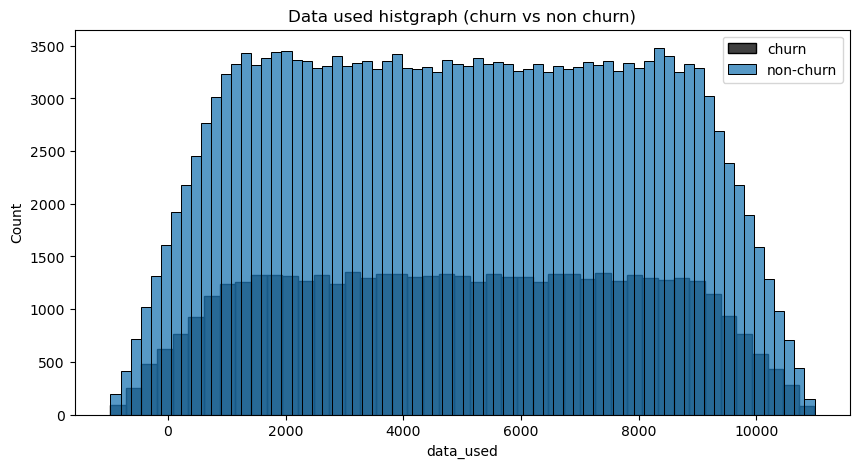

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(churn_data_used,label="churn",color="black")
sns.histplot(nonchurn_data_used,label="non-churn")
plt.title("Data used histgraph (churn vs non churn)")
plt.legend()
plt.show()

In [ ]:
churn_dep=data[data['churn']==1]['num_dependents']
nonchurn_dep=data[data['churn']==0]['num_dependents']

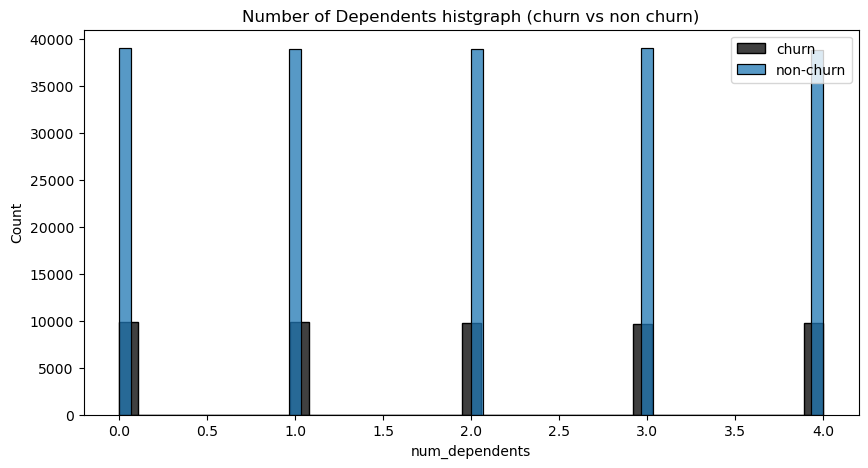

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(churn_dep,label="churn",color="black")
sns.histplot(nonchurn_dep,label="non-churn")
plt.title("Number of Dependents histgraph (churn vs non churn)")
plt.legend()
plt.show()

Графики говорят о том, что количество ушедших от операторов встречаются меньше, но пропорции и характер гистограммы сохраняются для разных групп.

Предположим, что у тех, кто ушел от оператора была меньше зарплата, меньше сделанных звонков, меньше использованных данных и больше людей на иждивении. Проведем анализ по двум исследоуемым группам и изучим их характеристики в зависимости от возраста.

In [ ]:
grouped = data.groupby(['age', 'churn'])['estimated_salary'].mean().reset_index()
grouped

,age,churn,estimated_salary
0,18,0,85044.375151
1,18,1,83862.263415
2,19,0,84953.534101
3,19,1,84758.847437
4,20,0,86447.008965
...,...,...,...
109,72,1,85305.354143
110,73,0,84536.205039
111,73,1,85725.054502
112,74,0,83994.847650


In [ ]:
churn_1 = grouped.query("churn == 1")
churn_0 = grouped.query("churn == 0")

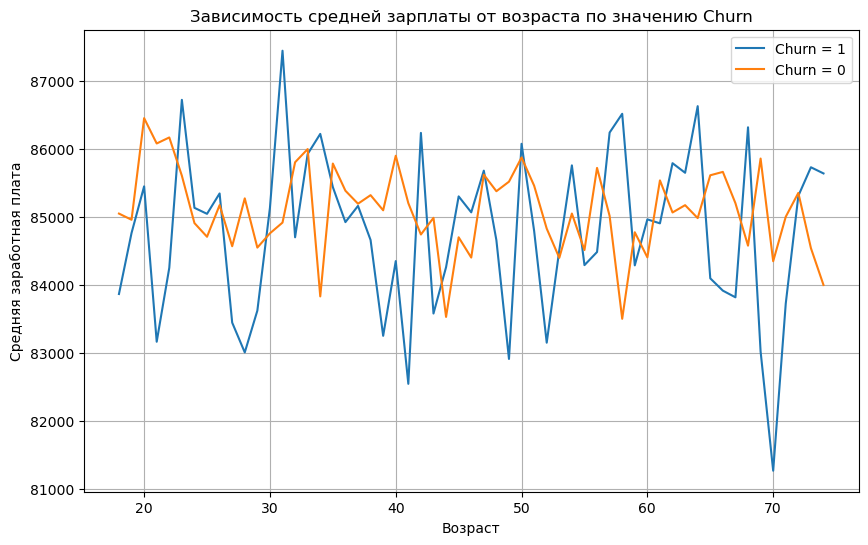

Средняя зарплата, у ушедших от оператора:
84771.52749503349
Средняя зарплата, у оставшихся:
85083.72693425634


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(churn_1['age'], churn_1['estimated_salary'], label='Churn = 1')
plt.plot(churn_0['age'], churn_0['estimated_salary'], label='Churn = 0')
plt.xlabel('Возраст')
plt.ylabel('Средняя заработная плата')
plt.title('Зависимость средней зарплаты от возраста по значению Churn')
plt.legend()
plt.grid(True)
plt.show()

print("Средняя зарплата, у ушедших от оператора:")
print(data[data['churn'] == 1]['estimated_salary'].mean())
print("Средняя зарплата, у оставшихся:")
print(data[data['churn'] == 0]['estimated_salary'].mean())

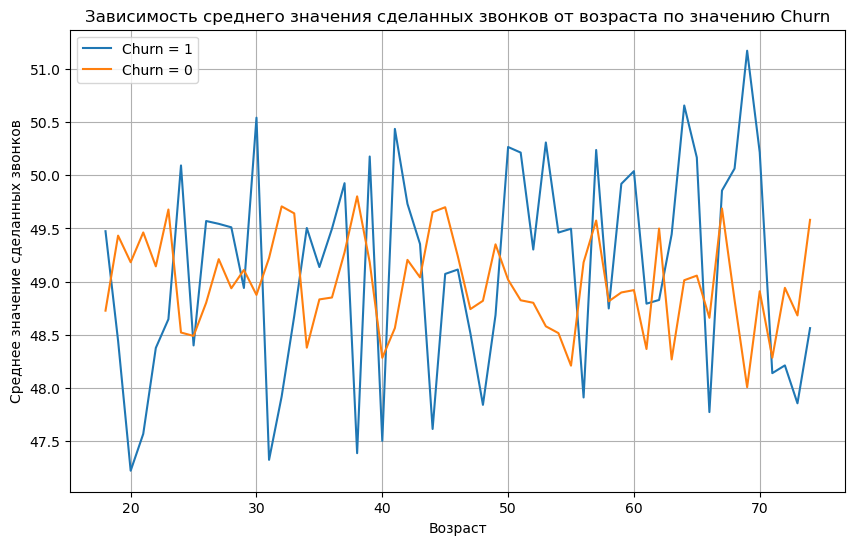

Среднее количество звонков, у ушедших от оператора:
49.11008253630164
Среднее количество звонков, у оставшихся:
48.9855900085248


In [ ]:
grouped_1 = data.groupby(['age', 'churn'])['calls_made'].mean().reset_index()

# Разделение данных на два набора: churn == 1 и churn == 0
churn_1 = grouped_1.query("churn == 1")
churn_0 = grouped_1.query("churn == 0")

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(churn_1['age'], churn_1['calls_made'], label='Churn = 1')
plt.plot(churn_0['age'], churn_0['calls_made'], label='Churn = 0')
plt.xlabel('Возраст')
plt.ylabel('Среднее значение сделанных звонков')
plt.title('Зависимость среднего значения сделанных звонков от возраста по значению Churn')
plt.legend()
plt.grid(True)
plt.show()

print("Среднее количество звонков, у ушедших от оператора:")
print(data[data['churn'] == 1]['calls_made'].mean())
print("Среднее количество звонков, у оставшихся:")
print(data[data['churn'] == 0]['calls_made'].mean())

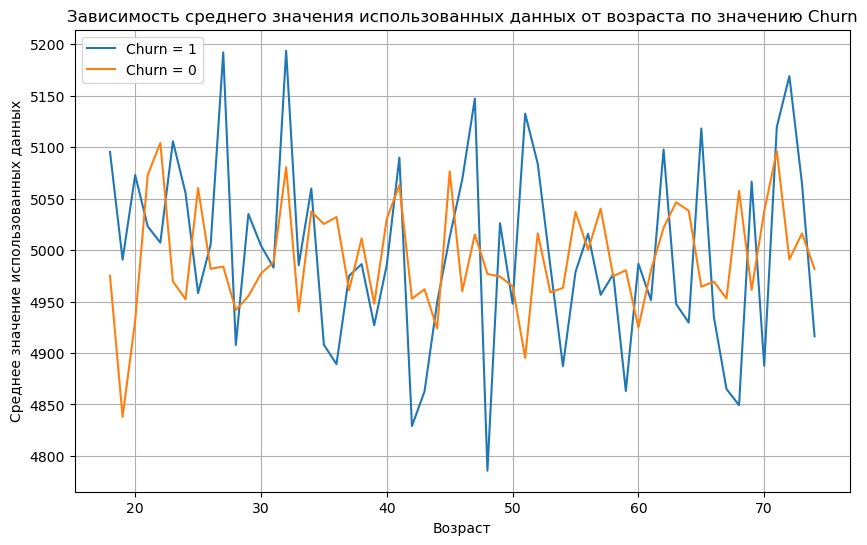

Среднее значение использованных данных, у ушедших от оператора:
4997.485510066152
Среднее значение использованных данных, у оставшихся:
4992.107941415116


In [ ]:
grouped_1 = data.groupby(['age', 'churn'])['data_used'].mean().reset_index()

# Разделение данных на два набора: churn == 1 и churn == 0
churn_1 = grouped_1.query("churn == 1")
churn_0 = grouped_1.query("churn == 0")

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(churn_1['age'], churn_1['data_used'], label='Churn = 1')
plt.plot(churn_0['age'], churn_0['data_used'], label='Churn = 0')
plt.xlabel('Возраст')
plt.ylabel('Среднее значение использованных данных')
plt.title('Зависимость среднего значения использованных данных от возраста по значению Churn')
plt.legend()
plt.grid(True)
plt.show()

print("Среднее значение использованных данных, у ушедших от оператора:")
print(data[data['churn'] == 1]['data_used'].mean())
print("Среднее значение использованных данных, у оставшихся:")
print(data[data['churn'] == 0]['data_used'].mean())

Проведенный анализ графиков не подтверждает того, что количество сделанных звонков, использование данных или зарплата у какой-то из групп выше или ниже, тем более видна сильняя волатильность, если на оси Х стоит возраст.

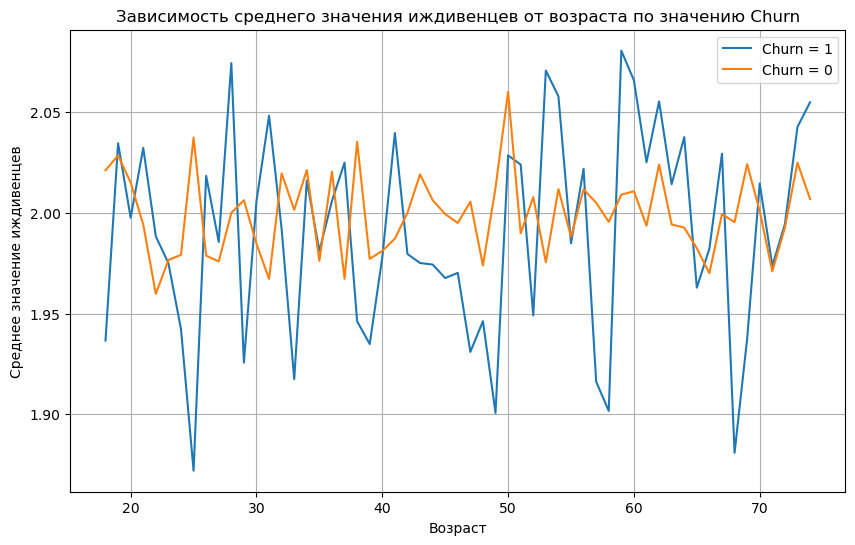

Среднее значение иждивенцев, у ушедших от оператора:
1.990312736805456
Среднее значение иждивенцев, у оставшихся:
1.9993015827367686


In [ ]:
grouped_1 = data.groupby(['age', 'churn'])['num_dependents'].mean().reset_index()

# Разделение данных на два набора: churn == 1 и churn == 0
churn_1 = grouped_1.query("churn == 1")
churn_0 = grouped_1.query("churn == 0")

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(churn_1['age'], churn_1['num_dependents'], label='Churn = 1')
plt.plot(churn_0['age'], churn_0['num_dependents'], label='Churn = 0')
plt.xlabel('Возраст')
plt.ylabel('Среднее значение иждивенцев')
plt.title('Зависимость среднего значения иждивенцев от возраста по значению Churn')
plt.legend()
plt.grid(True)
plt.show()

print("Среднее значение иждивенцев, у ушедших от оператора:")
print(data[data['churn'] == 1]['num_dependents'].mean())
print("Среднее значение иждивенцев, у оставшихся:")
print(data[data['churn'] == 0]['num_dependents'].mean())

Здесь оранжевая линия (остались) менее волатильна, чем голубая (ушли). Но также никаких существенных различий в количестве иждивенцев не обнаружено между двумя группами.

Итак, предположение не подтвердилось на графиках.

In [ ]:
# 3. Преобразование данных
data['calls_made'] = data['calls_made'].apply(lambda x: x if x >= 0 else 0)
data['sms_sent'] = data['sms_sent'].apply(lambda x: x if x >= 0 else 0)
data['data_used'] = data['data_used'].apply(lambda x: x if x >= 0 else 0)

data['date_of_registration'] = pd.to_datetime(data['date_of_registration'])
data['registration_year'] = data['date_of_registration'].dt.year
data['registration_month'] = data['date_of_registration'].dt.month

# Кодирование категориальных переменных
data = pd.get_dummies(data, columns=['telecom_partner', 'gender', 'state', 'city'], drop_first=True)

# Логарифмирование
data['log_estimated_salary'] = np.log(data['estimated_salary'] + 1)  # +1, чтобы избежать логарифма нуля

# 5. Нормализация/стандартизация
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data[['calls_made', 'sms_sent', 'data_used']] = scaler.fit_transform(data[['calls_made', 'sms_sent', 'data_used']])

# 6. Разделение на обучающую и тестовую выборки
X = data.drop(['customer_id', 'churn', 'date_of_registration'], axis=1)  # Удаление ненужных колонок
y = data['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Logistic Regression
### Базовая модель

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)
conf_lr = confusion_matrix(y_test, y_pred_lr)
clf_report_lr = classification_report(y_test, y_pred_lr)

print("Logistic Regression Metrics:")
print(f"Accuracy: {acc_lr:.2f}")
print(f"F1 Score: {f1_lr:.2f}")
print(f"AUC-ROC: {auc_lr:.2f}")
print(f"Classification Report : \n{clf_report_lr}")
print(f"Confusion Matrix: \n{conf_lr}")

Logistic Regression Metrics:
Accuracy: 0.80
F1 Score: 0.00
AUC-ROC: 0.50
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     58412
           1       0.00      0.00      0.00     14654

    accuracy                           0.80     73066
   macro avg       0.40      0.50      0.44     73066
weighted avg       0.64      0.80      0.71     73066

Confusion Matrix: 
[[58412     0]
 [14654     0]]


C:\Users\nezhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nezhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\nezhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

### Интерпретация результатов базовой модели

1. **Метрики:**
   - **Accuracy (Точность)**: 80% — это общий процент правильных предсказаний модели. Он высокий, но так как модель предсказывает только один класс (`0`), это не показатель ее реальной способности прогнозировать отток (`1`).
   - **F1 Score**: 0.00 для класса `1`, так как модель вообще не предсказывает отток (все предсказания относятся к классу `0`). F1 учитывает как точность (precision), так и полноту (recall), но в данном случае для класса `1` обе эти метрики равны нулю.
   - **AUC-ROC**: 0.50 указывает на отсутствие дискриминации между классами, т.е. модель предсказывает не лучше случайного угадывания.
   - **Confusion Matrix**:
     ```
     [[58412     0]
      [14654     0]]
     ```
     Модель правильно предсказывает всех клиентов, не покинувших компанию, но ни одного клиента с оттоком. Это подчеркивает дисбаланс классов, который модель не учитывает.




### Балансировка классов с помощью oversampling

В первом шаге увеличим число примеров с оттоком (`1`) до количества, равного числу примеров без оттока (`0`), с использованием oversampling.

In [ ]:
# Увеличение числа наблюдений класса '1' для балансировки выборки
X_train_upsampled, y_train_upsampled = resample(
    X_train[y_train == 1],
    y_train[y_train == 1],
    replace=True,
    n_samples=X_train[y_train == 0].shape[0],
    random_state=42
)

# Объединяем upsampled класс '1' с оригинальным классом '0'
X_train_balanced = pd.concat([X_train[y_train == 0], X_train_upsampled])
y_train_balanced = pd.concat([y_train[y_train == 0], y_train_upsampled])


Теперь обучим логистическую регрессию на сбалансированной выборке и оценим результаты.

In [ ]:
lr_balanced = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)
lr_balanced.fit(X_train_balanced, y_train_balanced)

y_pred_balanced = lr_balanced.predict(X_test)
y_prob_balanced = lr_balanced.predict_proba(X_test)[:, 1]

acc_balanced = accuracy_score(y_test, y_pred_balanced)
f1_balanced = f1_score(y_test, y_pred_balanced)
auc_balanced = roc_auc_score(y_test, y_prob_balanced)
conf_balanced = confusion_matrix(y_test, y_pred_balanced)
clf_report_balanced = classification_report(y_test, y_pred_balanced)

print("Logistic Regression with Balanced Data Metrics:")
print(f"Accuracy: {acc_balanced:.2f}")
print(f"F1 Score: {f1_balanced:.2f}")
print(f"AUC-ROC: {auc_balanced:.2f}")
print(f"Classification Report : \n{clf_report_balanced}")
print(f"Confusion Matrix: \n{conf_balanced}")

Logistic Regression with Balanced Data Metrics:
Accuracy: 0.50
F1 Score: 0.29
AUC-ROC: 0.50
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.50      0.62     58412
           1       0.20      0.50      0.29     14654

    accuracy                           0.50     73066
   macro avg       0.50      0.50      0.45     73066
weighted avg       0.68      0.50      0.55     73066

Confusion Matrix: 
[[29454 28958]
 [ 7335  7319]]


Результаты модели на сбалансированной выборке показывают некоторые улучшения, особенно по **F1 Score** для класса `1` (отток), который теперь имеет ненулевое значение.

### Интерпретация

1. **Accuracy (Точность)**: Значение Accuracy теперь 0.50, что значительно ниже предыдущего, но это было ожидаемо, так как модель теперь более "внимательна" к классу `1`.
2. **F1 Score**: Значение F1 для класса `1` стало 0.29 — улучшение по сравнению с нулевым значением, которое мы видели ранее.
3. **AUC-ROC**: AUC-ROC всё ещё составляет 0.50, что указывает на необходимость улучшения модели.
4. **Confusion Matrix**:
   ```
   [[29454 28958]
    [ 7335  7319]]
   ```
   Модель теперь действительно предсказывает часть класса `1`, но в то же время она часто ошибается, предсказывая `1` для наблюдений класса `0`.




### Настройка гиперпараметров модели

Для дальнейшего улучшения модели настроим гиперпараметры с использованием `GridSearchCV`. Это позволит нам найти оптимальные значения параметров, которые могут улучшить способность модели к различению классов.


In [ ]:
# Определяем сетку гиперпараметров
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  # Регуляризация L1 = Lasso, L2 = Ridge
    'solver': ['liblinear']  # 'liblinear' совместим с обоими типами регуляризации
}

# Настройка GridSearchCV с перекрёстной проверкой
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42),
                           param_grid,
                           cv=5,
                           scoring='f1',
                           n_jobs=-1)

# Обучение GridSearchCV на сбалансированной выборке
grid_search.fit(X_train_balanced, y_train_balanced)

# Лучшие параметры
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


Обучение логистической регрессии с оптимальными параметрами

In [ ]:
# Обучаем модель с найденными оптимальными параметрами
best_lr = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', class_weight='balanced', random_state=42)
best_lr.fit(X_train_balanced, y_train_balanced)

# Предсказания и вероятности
y_pred_best = best_lr.predict(X_test)
y_prob_best = best_lr.predict_proba(X_test)[:, 1]

# Расчет метрик
acc_best = accuracy_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
auc_best = roc_auc_score(y_test, y_prob_best)
conf_best = confusion_matrix(y_test, y_pred_best)
clf_report_best = classification_report(y_test, y_pred_best)

# Вывод результатов
print("Optimized Logistic Regression Metrics:")
print(f"Accuracy: {acc_best:.2f}")
print(f"F1 Score: {f1_best:.2f}")
print(f"AUC-ROC: {auc_best:.2f}")
print(f"Classification Report : \n{clf_report_best}")
print(f"Confusion Matrix: \n{conf_best}")


Optimized Logistic Regression Metrics:
Accuracy: 0.49
F1 Score: 0.29
AUC-ROC: 0.50
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.49      0.61     58412
           1       0.20      0.52      0.29     14654

    accuracy                           0.49     73066
   macro avg       0.50      0.50      0.45     73066
weighted avg       0.68      0.49      0.54     73066

Confusion Matrix: 
[[28480 29932]
 [ 7012  7642]]


Результаты с оптимизированными гиперпараметрами дают такие же показатели **F1 Score** и **AUC-ROC**, как и предыдущая модель, хотя точность немного снизилась. Модель по-прежнему показывает высокую **точность для класса 0**, но **низкую для класса 1**. Это указывает на то, что логистическая регрессия может быть не лучшим выбором для этой задачи, так как она имеет сложности с классификацией редкого класса в дисбалансированных данных.

### Подбираем сетку параметров с помощью GridSearchCV

In [ ]:
# Обновляем сетку гиперпараметров для ElasticNet
param_grid_elastic = {
    'C': [0.001, 0.01, 0.1, 1, 10],       # Коэффициент регуляризации
    'l1_ratio': [0.1, 0.5, 0.7, 0.9],     # Соотношение L1 и L2 (ElasticNet)
    'penalty': ['elasticnet'],
    'solver': ['saga']                    # 'saga' поддерживает ElasticNet
}

# Настройка GridSearchCV для поиска лучших параметров
grid_search_elastic = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=500),
    param_grid_elastic,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Обучаем GridSearchCV на сбалансированной выборке
grid_search_elastic.fit(X_train_balanced, y_train_balanced)

# Получаем лучшие параметры
best_params_elastic = grid_search_elastic.best_params_
print("Best parameters for ElasticNet: ", best_params_elastic)


Best parameters for ElasticNet:  {'C': 0.01, 'l1_ratio': 0.7, 'penalty': 'elasticnet', 'solver': 'saga'}

### Применение ADASYN для балансировки данных с подобранными оптимальными параметрами

In [ ]:
# Применяем ADASYN для создания сбалансированного тренировочного набора
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Повторное обучение модели с оптимальными гиперпараметрами
optimized_lr = LogisticRegression(
    C=0.01,
    l1_ratio=0.7,
    penalty='elasticnet',
    solver='saga',
    class_weight='balanced',
    random_state=42)
optimized_lr.fit(X_train_adasyn, y_train_adasyn)

# Предсказания и вероятности для тестовой выборки
y_pred_adasyn = optimized_lr.predict(X_test)
y_prob_adasyn = optimized_lr.predict_proba(X_test)[:, 1]

# Расчет метрик
acc_adasyn = accuracy_score(y_test, y_pred_adasyn)
f1_adasyn = f1_score(y_test, y_pred_adasyn)
auc_adasyn = roc_auc_score(y_test, y_prob_adasyn)
conf_adasyn = confusion_matrix(y_test, y_pred_adasyn)
clf_report_adasyn = classification_report(y_test, y_pred_adasyn)

# Вывод результатов
print("ADASYN Logistic Regression Metrics:")
print(f"Accuracy: {acc_adasyn:.2f}")
print(f"F1 Score: {f1_adasyn:.2f}")
print(f"AUC-ROC: {auc_adasyn:.2f}")
print(f"Classification Report : \n{clf_report_adasyn}")
print(f"Confusion Matrix: \n{conf_adasyn}")


C:\Users\nezhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\nezhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


ADASYN Logistic Regression Metrics:
Accuracy: 0.51
F1 Score: 0.29
AUC-ROC: 0.50
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.51      0.62     58412
           1       0.20      0.49      0.29     14654

    accuracy                           0.51     73066
   macro avg       0.50      0.50      0.45     73066
weighted avg       0.68      0.51      0.55     73066

Confusion Matrix: 
[[29722 28690]
 [ 7430  7224]]


C:\Users\nezhu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Интерпретация результатов с использованием ADASYN и модели логистической регрессии показывает, что несмотря на балансировку классов, добиться высокой точности предсказания оттока не удалось.

### Интерпретация:
1. **Accuracy (Точность) — 51%**: модель верно классифицирует примерно половину всех наблюдений.
  
2. **F1 Score для класса 1 — 0.29**: значение F1 для класса оттока остаётся низким, указывая на сложности модели в нахождении оптимального компромисса между точностью и полнотой. Хотя ADASYN повысил F1 для класса 1 до 0.29.

3. **Classification Report и Confusion Matrix**: отчёт показывает, что модель имеет высокий recall (полноту) для класса 0, но не для класса 1. Конфузионная матрица подтверждает это: модель ошибается в 49% случаев, предсказывая отток.

### Вывод
Возможно, особенности данных, такие как высокие различия между классами, структурная несбалансированность или ограниченное количество значимых признаков, сказываются на качестве предсказания.

In [ ]:
coefficients = optimized_lr.coef_.flatten()
intercept = optimized_lr.intercept_

coef_df = pd.DataFrame({"Variable": X_train.columns, "Coefficient": coefficients})
coef_df = coef_df.sort_values(by="Coefficient", ascending=False)  # Сортировка по значению коэффициента

coef_df


,Variable,Coefficient
12,gender_M,2.353636e-06
10,telecom_partner_Reliance Jio,1.875557e-06
11,telecom_partner_Vodafone,1.861889e-06
9,telecom_partner_BSNL,1.849687e-06
42,city_Hyderabad,1.468091e-06
43,city_Kolkata,1.416636e-06
44,city_Mumbai,1.362639e-06
41,city_Delhi,1.350596e-06
40,city_Chennai,1.343878e-06
21,state_Jharkhand,3.831512e-07




### Общая интерпретация
1. **Малые коэффициенты**: Множество коэффициентов имеют очень малые значения, близкие к нулю. Это указывает на то, что некоторые переменные (например, город и штат проживания, партнер телекоммуникационной компании) оказывают незначительное влияние на предсказание целевой переменной. Хотя их вклад статистически значим, экономически он минимален.

2. **Значимость признаков**: Наиболее влиятельные переменные имеют как положительные, так и отрицательные коэффициенты, что показывает различное направление влияния.

3. **Отрицательные и положительные признаки**: Положительные коэффициенты увеличивают шансы на положительный исход (например, отток пользователя), тогда как отрицательные — уменьшают его.

### Интерпретация по группам переменных
1. **Возраст (age)** и **число иждивенцев (num_dependents)** имеют самые высокие отрицательные значения коэффициентов:
   - **Возраст**: Чем старше пользователь, тем ниже вероятность оттока. Это может указывать на более устойчивые предпочтения в услугах с увеличением возраста.
   - **Число иждивенцев**: Большее количество иждивенцев снижает шансы на отток, вероятно, из-за зависимости семьи от стабильного телекоммуникационного партнера.

2. **Дата регистрации (registration_year и registration_month)** также имеют отрицательные значения:
   - **Регистрация в последние годы** ассоциируется с меньшей вероятностью ухода, что может указывать на растущую лояльность новых клиентов.

3. **Город и штат проживания** (например, `city_Hyderabad`, `state_Jharkhand`):
   - Хотя большинство из этих факторов имеет небольшие положительные значения, их влияние на шансы оттока незначительно. Это может быть связано с особенностями региона (например, уровень конкуренции в конкретных городах/штатах), но оно не играет ведущей роли.

4. **Пол (gender_M)**:
   - Маленькое положительное значение коэффициента может указывать на незначительно более высокие шансы на отток у мужчин по сравнению с женщинами.

5. **Телекоммуникационные партнеры** (`telecom_partner_Vodafone`, `telecom_partner_Reliance Jio` и т.д.):
   - Хотя эти переменные включены в модель, их влияние невелико, что говорит о минимальном эффекте партнера на решение о прекращении использования услуг.

6. **Скорректированная зарплата (log_estimated_salary)** и **зарплата (estimated_salary)**:
   - Зарплата не оказывает значимого влияния (так как коэффициенты практически нулевые), что указывает на то, что уровень дохода не является определяющим фактором для лояльности к провайдеру.

### Основные выводы
Наиболее значимыми факторами для вероятности оттока являются **возраст** и **число иждивенцев** — с увеличением этих факторов вероятность ухода снижается. Влияние других переменных минимально, что может означать, что экономическое или демографическое положение пользователя (включая регион проживания) не сильно определяет его решение об оттоке.

Посмотрим на предельные эффекты:

In [ ]:
import statsmodels.api as sm

X_train_adasyn = X_train_adasyn.astype(int)

X_train_sm = sm.add_constant(X_train_adasyn)

logit_model = sm.Logit(y_train_adasyn, X_train_sm)
result = logit_model.fit()

marginal_effects = result.get_margeff(at='mean', method='dydx')
print(marginal_effects.summary())

Optimization terminated successfully.
         Current function value: 0.377680
         Iterations 9
        Logit Marginal Effects       
Dep. Variable:                  churn
Method:                          dydx
At:                              mean
                                  dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
age                           1.881e-05   7.58e-05      0.248      0.804      -0.000       0.000
pincode                       9.595e-09   4.71e-09      2.037      0.042    3.64e-10    1.88e-08
num_dependents                  -0.0100      0.001    -11.315      0.000      -0.012      -0.008
estimated_salary             -3.604e-08   5.32e-08     -0.677      0.498    -1.4e-07    6.82e-08
calls_made                       0.0003      0.002      0.140      0.889      -0.004       0.004
sms_sent                        -0.0031      0.002     -1.626      

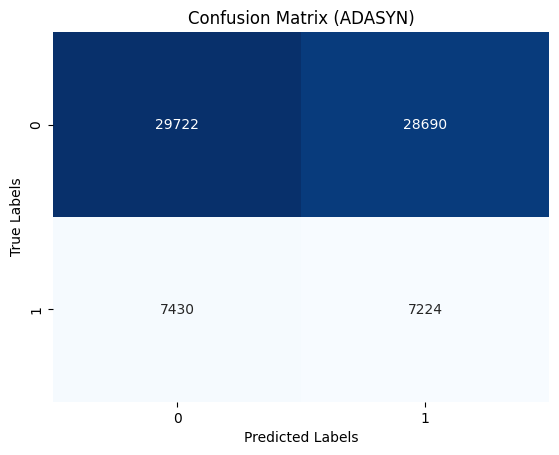

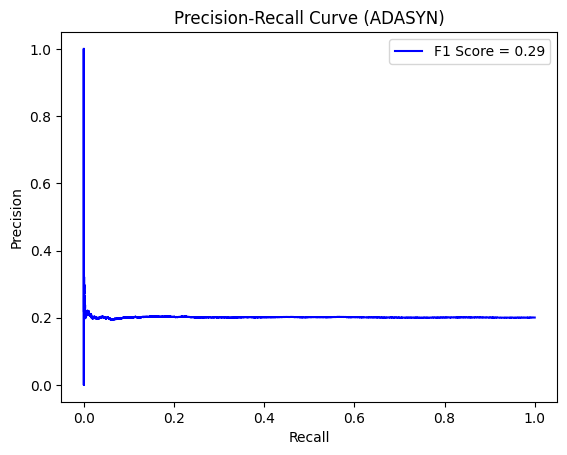

In [ ]:
# Confusion Matrix
sns.heatmap(conf_adasyn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix (ADASYN)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_adasyn)
plt.plot(recall, precision, color="blue", label=f"F1 Score = {f1_adasyn:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (ADASYN)")
plt.legend()
plt.show()

# Gradient Boosting

### Базовая модель

In [ ]:
gbc = GradientBoostingClassifier()

gbc.fit(X_train, y_train)

y_pred_gb = gbc.predict(X_test)
y_prob_gb = gbc.predict_proba(X_test)[:, 1]

accuracy_gb = accuracy_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)
auc_roc_gb = roc_auc_score(y_test, y_prob_gb)
conf_gb = confusion_matrix(y_test, y_pred_gb)
clf_report_gb = classification_report(y_test, y_pred_gb)

print("Gradient Boosting Metrics:")
print("Accuracy:", accuracy_gb)
print("F1 Score:", f1_gb)
print("AUC-ROC:", auc_roc_gb)
print(f"Classification Report : \n{clf_report_gb}")
print(f"Confusion Matrix : \n{conf_gb}")

Gradient Boosting Metrics:
Accuracy: 0.7994279144882709
F1 Score: 0.00013645357167223852
AUC-ROC: 0.49974377122861985
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      1.00      0.89     58412
           1       0.33      0.00      0.00     14654

    accuracy                           0.80     73066
   macro avg       0.57      0.50      0.44     73066
weighted avg       0.71      0.80      0.71     73066

Confusion Matrix : 
[[58410     2]
 [14653     1]]


### 1. **Обзор метрик**
   - **Accuracy (Точность)**: 0.80 — модель правильно предсказала 80% классов, однако это значение вводит в заблуждение из-за дисбаланса классов.
   - **F1 Score**: 0.00 для класса оттока — очень низкий F1 Score указывает на плохую работу модели в отношении пользователей, которые уходят. Это происходит из-за низкой точности и полноты для этого класса.
   - **AUC-ROC**: 0.50 — модель не отличает класс, работая на уровне случайного угадывания.

### 2. **Конфузионная матрица**
   - **[58410, 2]**: Верно классифицированные остающиеся пользователи и лишь 2 ошибки первого рода (неправильное определение остающихся как уходящих).
   - **[14653, 1]**: Почти все пользователи, склонные к оттоку, были классифицированы неправильно.

### 3. **Экономическая интерпретация**
   Неспособность модели правильно выявить пользователей, склонных к оттоку, приводит к:
   - **Упущенным возможностям**: поскольку почти всех "уходящих" пользователей модель определяет неверно, нет возможности своевременно предпринять меры для их удержания.
   - **Затратам на удержание нецелевых пользователей**: хотя ложных положительных классификаций (ошибок первого рода) крайне мало, в текущем состоянии модель не добавляет значимой информации для принятия решений по удержанию.

### 4. **Заключение и рекомендации**
   Эта базовая модель недостаточно эффективна для задачи предсказания оттока и требует улучшений.
   - Для улучшения качества модели подберем
    гиперпараметры с помощью GridSearchCV, в частности, параметр `max_depth`, `learning_rate` и `n_estimators`.
   - В дальнейшем рассмотрим другие методы, например, ансамблевые модели, чтобы улучшить способность модели выявлять пользователей, склонных к оттоку.


### Подбираем параметры

In [ ]:
# Параметры для подбора
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# GridSearchCV для поиска лучших параметров
gbc = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Лучшая модель
best_gbc = grid_search.best_estimator_

# Оценка на тестовой выборке
y_pred_best_gb = best_gbc.predict(X_test)
y_prob_best_gb = best_gbc.predict_proba(X_test)[:, 1]

# Метрики
accuracy_best_gb = accuracy_score(y_test, y_pred_best_gb)
f1_best_gb = f1_score(y_test, y_pred_best_gb)
auc_roc_best_gb = roc_auc_score(y_test, y_prob_best_gb)
conf_best_gb = confusion_matrix(y_test, y_pred_best_gb)
clf_report_best_gb = classification_report(y_test, y_pred_best_gb)

print("Optimized Gradient Boosting Metrics:")
print("Accuracy:", accuracy_best_gb)
print("F1 Score:", f1_best_gb)
print("AUC-ROC:", auc_roc_best_gb)
print(f"Classification Report : \n{clf_report_best_gb}")
print(f"Confusion Matrix : \n{conf_best_gb}")


Optimized Gradient Boosting Metrics:
Accuracy: 0.7947198423343279
F1 Score: 0.015232092443043792
AUC-ROC: 0.501178471968079
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     58412
           1       0.20      0.01      0.02     14654

    accuracy                           0.79     73066
   macro avg       0.50      0.50      0.45     73066
weighted avg       0.68      0.79      0.71     73066

Confusion Matrix : 
[[57951   461]
 [14538   116]]


In [ ]:
print(best_gbc)

GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=200,
                           subsample=0.8)


### Интерпретация метрик модели:

1. **Точность (Accuracy = 0.79)** — модель правильно предсказывает класс примерно в 79% случаев. В данном случае, точность полезна для общего понимания производительности, но из-за несбалансированности классов её стоит оценивать наряду с другими метриками.

2. **F1 Score для класса 1 (целевой) = 0.015** — низкое значение показывает, что модель имеет затруднения в правильной классификации редких событий (класса 1), так как F1 объединяет точность и полноту. Это можно объяснить значительным дисбалансом классов, где встречаемость класса 1 низкая.

3. **AUC-ROC = 0.50** — модель не даёт преимущества в ранжировании вероятностей, близкое к 0.5 значение указывает, что модель не разделяет классы лучше случайного угадывания. Это свидетельствует о проблемах с распознаванием класса 1.

4. **Classification Report и Confusion Matrix** — подавляющая часть предсказаний приходится на класс 0 (57951 против 461 ошибок), что подчёркивает дисбаланс. Модель практически не идентифицирует класс 1 (только 116 корректных предсказаний из 14654 примеров).

### Экономическая интерпретация:

При анализе на практике, экономическая интерпретация результатов могла бы заключаться в следующем:

- **Эффективность классификации**: При такой значительной точности для класса 0, но низком F1 для класса 1, модель может быть эффективной для задач, где ложные срабатывания на класс 1 (ошибочные предсказания редкого события) не критичны для конечного результата или допускаются.

- **Риски и возможности**: В экономическом контексте, такая модель может быть полезна для определения случаев, когда события, относящиеся к классу 1, не предполагают значительных затрат или потерь. Однако, если эти события связаны с риском или потенциальной прибылью, вероятно, потребуется доработка модели или даже методология, позволяющая работать с несбалансированными данными более эффективно.

- **Снижение затрат на редкие случаи**: Поскольку модель очень точно идентифицирует большинство наблюдений как класс 0, это может помочь в экономии ресурсов на случаи, не требующие интенсивного вмешательства, если редкие события (класс 1) не оказывают значительного воздействия на результат.

Подводя итог, данная модель может быть экономически полезна в задачах, где подавляющее большинство событий действительно принадлежит к классу 0, и ошибки в редком классе можно допускать с минимальными экономическими потерями. Если же экономические последствия ошибок в классе 1 значительны, стоит рассмотреть дальнейшую оптимизацию или альтернативные методы.

### Расчет precision_score, recall_score и визуализация Gradient Boosting с уже подобранными параметрами

In [ ]:
best_gbc = GradientBoostingClassifier(learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8)
best_gbc.fit(X_train, y_train)

y_pred_best_gb = best_gbc.predict(X_test)
y_prob_best_gb = best_gbc.predict_proba(X_test)[:, 1]

accuracy_best_gb = accuracy_score(y_test, y_pred_best_gb)
f1_best_gb = f1_score(y_test, y_pred_best_gb)
auc_roc_best_gb = roc_auc_score(y_test, y_prob_best_gb)
precision_best_gb = precision_score(y_test, y_pred_best_gb)
recall_best_gb = recall_score(y_test, y_pred_best_gb)
conf_best_gb = confusion_matrix(y_test, y_pred_best_gb)
clf_report_best_gb = classification_report(y_test, y_pred_best_gb)

print("Optimized Gradient Boosting Metrics:")
print("Accuracy:", accuracy_best_gb)
print("F1 Score:", f1_best_gb)
print("AUC-ROC:", auc_roc_best_gb)
print(f"Classification Report : \n{clf_report_best_gb}")
print(f"Confusion Matrix : \n{conf_best_gb}")
print(f"Precision_score : {precision_best_gb}")
print(f"Recall_score : {recall_best_gb}")


Optimized Gradient Boosting Metrics:
Accuracy: 0.794309254646484
F1 Score: 0.015202149269379463
AUC-ROC: 0.49799990992201865
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.99      0.89     58412
           1       0.19      0.01      0.02     14654

    accuracy                           0.79     73066
   macro avg       0.50      0.50      0.45     73066
weighted avg       0.68      0.79      0.71     73066

Confusion Matrix : 
[[57921   491]
 [14538   116]]
Precision_score : 0.19110378912685339
Recall_score : 0.007915927391838405


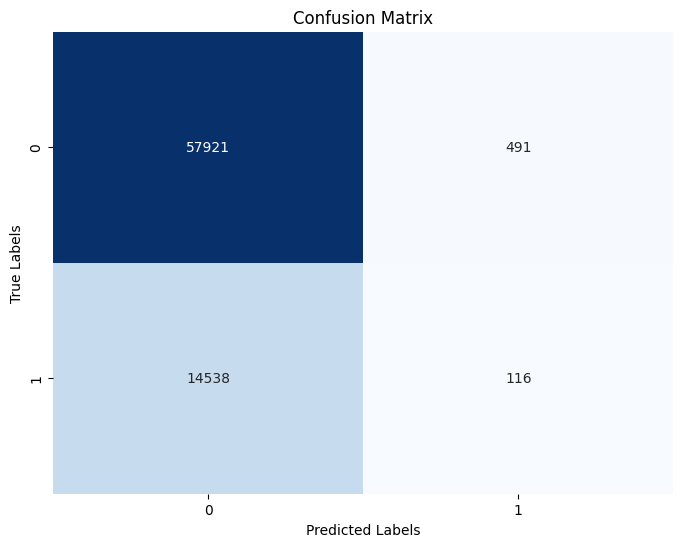

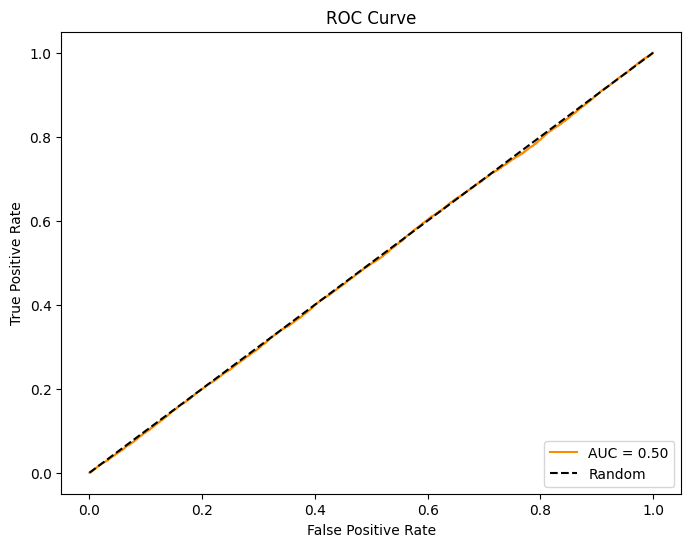

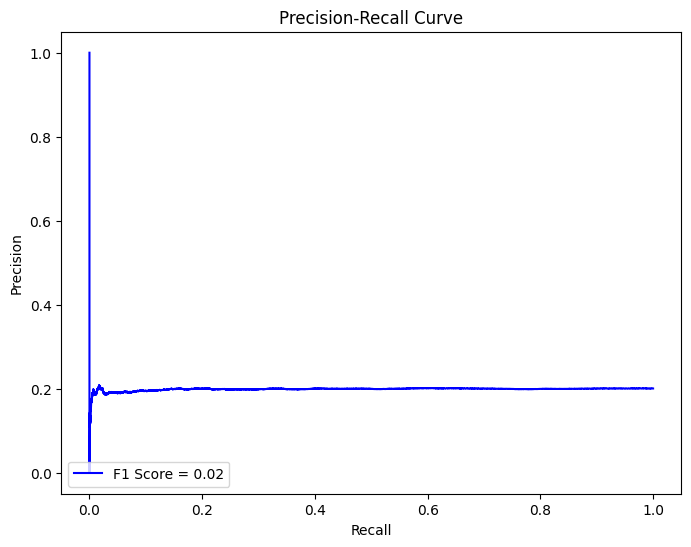

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_best_gb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_prob_best_gb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_roc_best_gb:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_prob_best_gb)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color="blue", label=f"F1 Score = {f1_best_gb:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


# Random Forest - базовая модель

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Обучим модель
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Оценим точность модели на тестовой выборке
rf_score = rf_model.score(X_test, y_test)
rf_score

0.7994416007445323

## Настройка гиперпараметров с помощью GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Параметры для Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Настройка GridSearchCV для Random Forest
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, n_jobs=-1, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Лучшие параметры для модели
rf_best_params = rf_grid_search.best_params_

rf_best_params

In [ ]:
# Обучаем модель с подобранными гиперпараметрами
rf_model = RandomForestClassifier(max_depth= None, min_samples_leaf= 1,
                                  min_samples_split= 2, n_estimators= 200,
                                  random_state=42)

# Обучаем модель
rf_model.fit(X_train, y_train)

# Прогнозы на тестовой выборке
rf_predictions = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)[:, 1]


In [ ]:
accuracy_rf = accuracy_score(y_test, rf_predictions)
f1_rf = f1_score(y_test, rf_predictions)
roc_auc_rf = roc_auc_score(y_test, rf_prob)
precision_rf = precision_score(y_test, rf_predictions)
recall_rf = recall_score(y_test, rf_predictions)

print("Accuracy:", accuracy_rf)
print("F1 Score:", f1_rf)
print("Precision:", roc_auc_rf)
print("Recall:", precision_rf)
print("AUC-ROC:", recall_rf)

Accuracy: 0.7994416007445323
F1 Score: 0.0
Precision: 0.5019204593152722
Recall: 0.0
AUC-ROC: 0.0


C:\Users\79174\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Интерпретация результатов
* Модель верно предсказала результат для примерно 80% данных. Однако эта метрика может быть вводящей в заблуждение, поскольку отток клиентов, вероятно, сильно несбалансирован, и точность не отражает справедливость по отношению к редкому классу (оттоку).

* Показатель F1 Score нулевой, указывая на то, что модель не предсказала ни одного случая оттока верно. Поскольку F1 Score — это гармоническое среднее Precision и Recall, низкие значения обеих метрик привели к нулевому значению F1 Score.

* Довольно низкое значение Precision указывает на то, что модель верно классифицирует отток в половине случаев. Низкий Precision также связан с редкостью класса оттока: модель склонна давать много ложноположительных срабатываний.

* Значение AUC-ROC, равное 0.5, указывает на то, что модель не лучше случайного угадывания в различении классов. Это связано с тем, что модель не может успешно различать клиентов, склонных к оттоку, и остающихся клиентов.

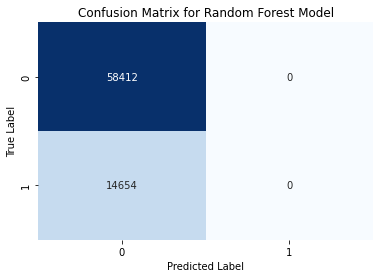

In [ ]:
# Матрица путаницы
conf_matrix = confusion_matrix(y_test, rf_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()



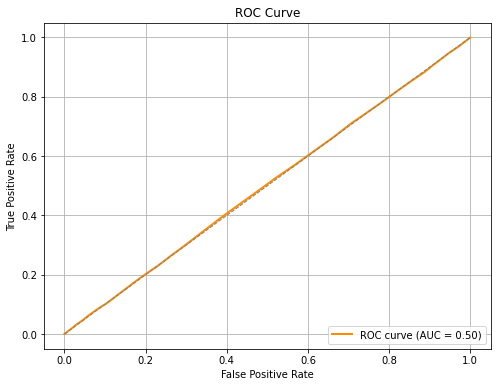

In [ ]:
# построим roc-кривую
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

## Применение SMOTE для балансировки классов

Применим метод SMOTE к обучающей выборке перед обучением. Метод SMOTE (Synthetic Minority Over-sampling Technique) может помочь сбалансировать данные, создавая синтетические примеры для меньшего класса.

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
rf_model_smote = RandomForestClassifier(max_depth= None, min_samples_leaf= 1,
                                  min_samples_split= 2, n_estimators= 200,
                                  random_state=42)

# Обучаем модель
rf_model_smote.fit(X_train_smote, y_train_smote)

# Прогнозы на тестовой выборке
rf_smote_predictions = rf_model_smote.predict(X_test)
rf_smote_prob = rf_model_smote.predict_proba(X_test)[:, 1]


accuracy_rf_smote = accuracy_score(y_test, rf_smote_predictions)
f1_rf_smote = f1_score(y_test, rf_smote_predictions)
roc_auc_rf_smote = roc_auc_score(y_test, rf_smote_prob)
precision_rf_smote = precision_score(y_test, rf_smote_predictions)
recall_rf_smote = recall_score(y_test, rf_smote_predictions)

print("Accuracy (SMOTE):", accuracy_rf_smote)
print("F1 Score (SMOTE):", f1_rf_smote)
print("Precision (SMOTE):", precision_rf_smote)
print("Recall (SMOTE):", recall_rf_smote)
print("AUC-ROC (SMOTE):", roc_auc_rf_smote)

Accuracy (SMOTE): 0.7880135767662114
F1 Score (SMOTE): 0.03549411544928078
Precision (SMOTE): 0.20284697508896798
Recall (SMOTE): 0.019448614712706428
AUC-ROC (SMOTE): 0.5027222250810991


### Интерпретация результатов
* Точность немного снизилась, что ожидаемо, так как после балансировки классов модели стало сложнее угадывать преобладающий класс. Тем не менее, снижение незначительное, что показывает, что модель все еще способна предсказывать основные тенденции.
* После балансировки классов F1 Score повысился, но все еще остается низким. Это говорит о том, что модель предсказала часть оттока правильно, но общее качество предсказания редкого класса недостаточно для бизнес-задач.
* Precision упал после балансировки классов, так как модель теперь сильнее ориентирована на предсказание положительного класса, что увеличило долю ложноположительных предсказаний.
* После применения SMOTE Recall немного повысился. Теперь модель способна находить случаи оттока, но полнота по-прежнему низкая.

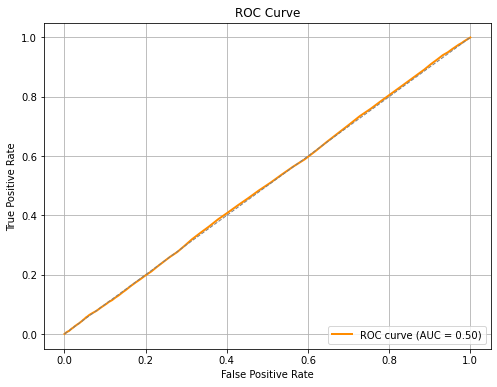

In [ ]:
# построим roc-кривую
fpr_rf_2, tpr_rf_2, _ = roc_curve(y_test, rf_smote_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_2, tpr_rf_2, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_rf_smote))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

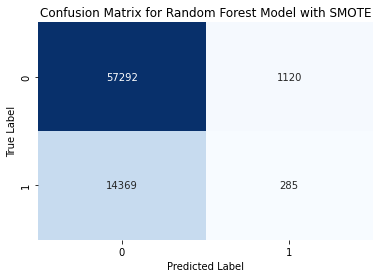

In [ ]:
# Матрица путаницы
conf_matrix = confusion_matrix(y_test, rf_smote_predictions)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Model with SMOTE')
plt.show()

# Более сложная модель - XGBoost

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [ ]:
y = y.values

Чтобы получить более точное представление о том, как работает наша модель, мы будем использовать StratifiedKFold вместо традиционного разделения на трейн и тест. Этот метод похож на кросс-валидацию, но разделяет данные на трейн и тест так, чтобы сохранялись пропорции классов.

C:\Users\73B5~1\AppData\Local\Temp/ipykernel_15812/3765436336.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=[f"Fold {i+1}" for i in range(len(scores))], x=scores, ax=ax2, palette='Set2')


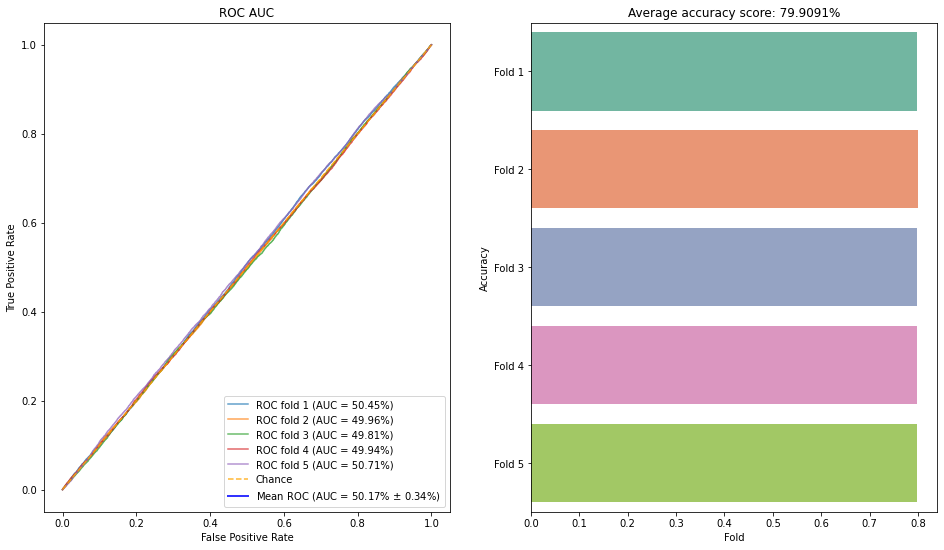

Среднее значение recall: 0.000737289439237607
Среднее значение precision: 0.20429876496052968


In [ ]:
scores = []
aucs = []
recalls = []
precisions = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]


    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
    roc_auc = auc(fpr, tpr)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    scores.append(score)
    aucs.append(roc_auc)
    recalls.append(rec)
    precisions.append(prec)


    sns.lineplot(x=fpr,
                 y=tpr,
                 alpha=0.7,
                 label=f'ROC fold {i+1} (AUC = {roc_auc:0.2%})',
                 ax=ax1)
sns.lineplot(x=[0, 1],
             y=[0, 1],
             linestyle='--',
             color='orange',
             label='Chance',
             alpha=.8,
             ax=ax1)

mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
ax1.plot(np.mean(fpr),
         np.mean(tpr),
         color='b',
         label=f'Mean ROC (AUC = {mean_auc:0.2%} $\pm$ {std_auc:0.2%})',
         lw=2,
         alpha=.8)

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC AUC')
ax1.legend(loc="lower right")


sns.barplot(y=[f"Fold {i+1}" for i in range(len(scores))], x=scores, ax=ax2, palette='Set2')
ax2.set_xlabel('Fold')
ax2.set_ylabel('Accuracy')
ax2.set_title(f"Average accuracy score: {np.mean(scores):.4%}")


plt.show()

print(f'Среднее значение recall: {np.mean(recalls)}')
print(f'Среднее значение precision: {np.mean(precisions)}')

На всех фолдах результаты примерно одинаковые.

# Ансамбль

Базовые модели RandomForestClassifier и GradientBoostingClassifier. Мета-модель - LogisticRegression.

In [ ]:
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42))
]

final_estimator = LogisticRegression()

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=final_estimator)

stacking_model.fit(X_train, y_train)

y_pred_stacking = stacking_model.predict(X_test)
y_prob_stacking = stacking_model.predict_proba(X_test)[:, 1]

accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)
roc_auc_stacking = roc_auc_score(y_test, y_prob_stacking)
precision_stacking = precision_score(y_test, y_pred_stacking)
recall_stacking = recall_score(y_test, y_pred_stacking)

print("Accuracy:", accuracy_stacking)
print("F1 Score:", f1_stacking)
print("Precision:", precision_stacking)
print("Recall:", recall_stacking)
print("AUC-ROC:", roc_auc_stacking)

Accuracy: 0.7994416007445323
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
AUC-ROC: 0.4984914333063906


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


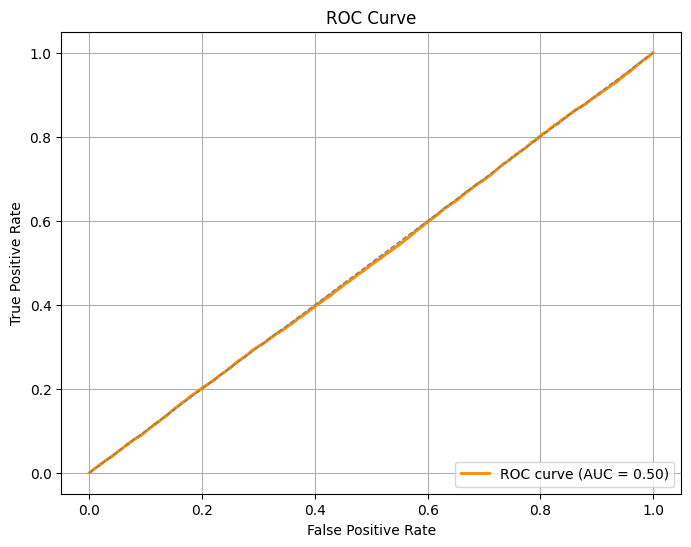

In [ ]:
# построим roc-кривую
fpr_stacking, tpr_stacking, _ = roc_curve(y_test, y_prob_stacking)
plt.figure(figsize=(8, 6))
plt.plot(fpr_stacking, tpr_stacking, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_stacking))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

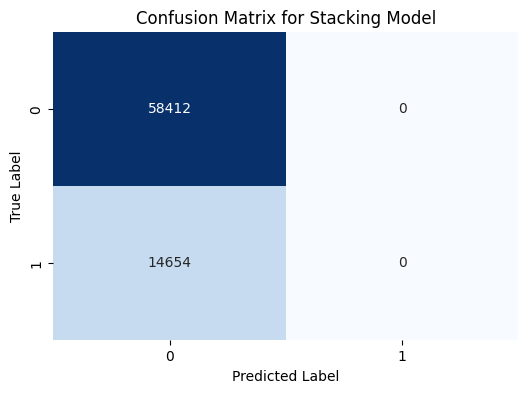

In [ ]:
# Матрица путаницы
conf_matrix = confusion_matrix(y_test, y_pred_stacking)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Stacking Model')
plt.show()

Результаты модели:

1. **Accuracy (точность): 0.799** — это достаточно высокая точность, что означает, что модель правильно классифицирует около 80% примеров. Однако высокая точность не всегда является надежным индикатором качества модели, особенно если данные несбалансированы.

2. **F1 Score: 0.0** — F1-метрика равна 0, что указывает на то, что модель не находит положительные примеры (классы, соответствующие "1" в целевой переменной). Это означает, что модель классифицирует почти все примеры как отрицательные (класс "0"). Вероятно, классовая дисбалансировка (много примеров одного класса по сравнению с другим) привела к тому, что модель не способна выявлять редкие случаи оттока клиентов.

3. **AUC-ROC: 0.498** — AUC-ROC около 0.5 говорит о том, что модель не отличается от случайной классификации. Значение около 0.5 означает, что модель не способна эффективно разделять положительные и отрицательные классы.


Применим метод SMOTE к обучающей выборке перед обучением. Метод SMOTE (Synthetic Minority Over-sampling Technique) может помочь сбалансировать данные, создавая синтетические примеры для меньшего класса.

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

stacking_model.fit(X_train_smote, y_train_smote)

y_pred_stacking_smote = stacking_model.predict(X_test)
y_prob_stacking_smote = stacking_model.predict_proba(X_test)[:, 1]

accuracy_stacking_smote = accuracy_score(y_test, y_pred_stacking_smote)
f1_stacking_smote = f1_score(y_test, y_pred_stacking_smote)
roc_auc_stacking_smote = roc_auc_score(y_test, y_prob_stacking_smote)
precision_stacking_smote = precision_score(y_test, y_pred_stacking_smote)
recall_stacking_smote = recall_score(y_test, y_pred_stacking_smote)

print("Accuracy (SMOTE):", accuracy_stacking_smote)
print("F1 Score (SMOTE):", f1_stacking_smote)
print("Precision (SMOTE):", precision_stacking_smote)
print("Recall (SMOTE):", recall_stacking_smote)
print("AUC-ROC (SMOTE):", roc_auc_stacking_smote)


Accuracy (SMOTE): 0.7090165056250514
F1 Score (SMOTE): 0.16120250917268317
Precision (SMOTE): 0.19105957168240906
Recall (SMOTE): 0.13941585915108504
AUC-ROC (SMOTE): 0.4964072304132051


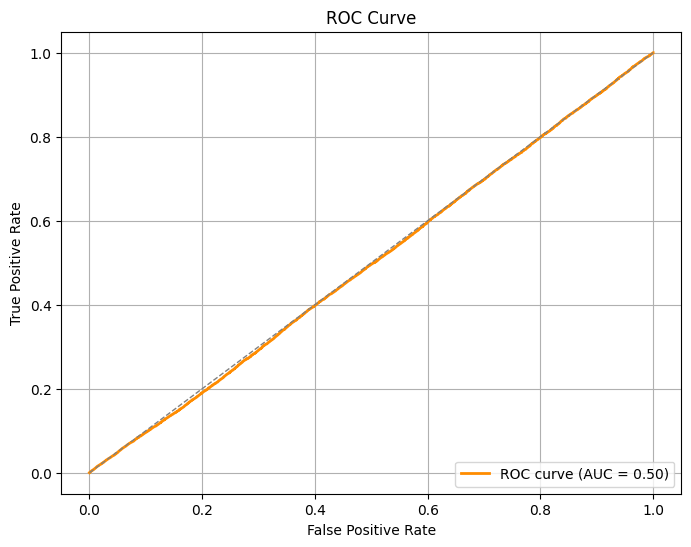

In [ ]:
# построим roc-кривую
fpr_stacking_2, tpr_stacking_2, _ = roc_curve(y_test, y_prob_stacking_smote)
plt.figure(figsize=(8, 6))
plt.plot(fpr_stacking_2, tpr_stacking_2, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_stacking_smote))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

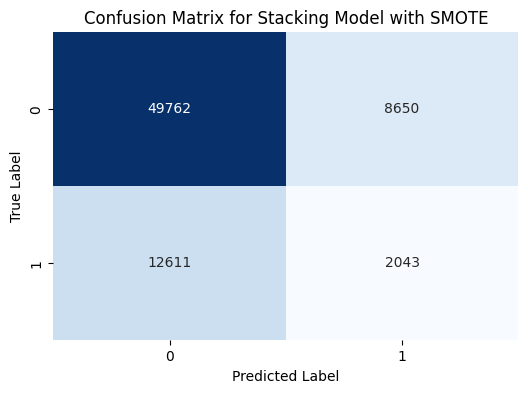

In [ ]:
# Матрица путаницы
conf_matrix = confusion_matrix(y_test, y_pred_stacking_smote)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Stacking Model with SMOTE')
plt.show()

Мы изменили базовую модель в стэкинге с GradientBoostingClassifier на XGBoost. XGBoost часто работает лучше с несбалансированными данными и предоставляет больше возможностей для оптимизации.

In [ ]:
from xgboost import XGBClassifier

base_learners = [
    ('rf', RandomForestClassifier(n_estimators=30, max_depth=5, class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(n_estimators=30, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=42))
]

final_estimator = LogisticRegression(class_weight='balanced')

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=final_estimator)

stacking_model.fit(X_train_smote, y_train_smote)

y_pred_stacking_xgb = stacking_model.predict(X_test)
y_prob_stacking_xgb = stacking_model.predict_proba(X_test)[:, 1]

accuracy_stacking_xgb = accuracy_score(y_test, y_pred_stacking_xgb)
f1_stacking_xgb = f1_score(y_test, y_pred_stacking_xgb)
roc_auc_stacking_xgb = roc_auc_score(y_test, y_prob_stacking_xgb)
precision_stacking_xgb = precision_score(y_test, y_pred_stacking_xgb)
recall_stacking_xgb = recall_score(y_test, y_pred_stacking_xgb)

print("Accuracy (XGBoost):", accuracy_stacking_xgb)
print("F1 Score (XGBoost):", f1_stacking_xgb)
print("Precision (XGBoost):", precision_stacking_xgb)
print("Recall (XGBoost):", recall_stacking_xgb)
print("AUC-ROC (XGBoost):", roc_auc_stacking_xgb)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:54:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:55:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:55:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:55:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:55:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Accuracy (XGBoost): 0.7825390742616265
F1 Score (XGBoost): 0.04839192669341798
Precision (XGBoost): 0.1977484092021537
Recall (XGBoost): 0.027569264364678586
AUC-ROC (XGBoost): 0.4979920696889172


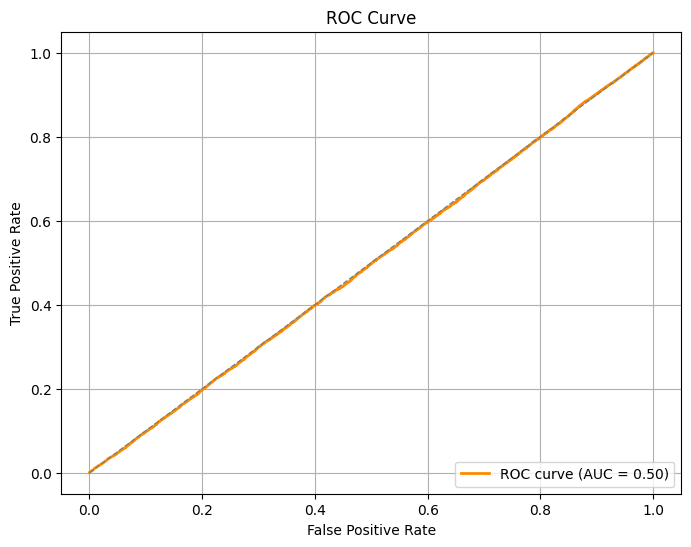

In [ ]:
# построим roc-кривую
fpr_stacking_3, tpr_stacking_3, _ = roc_curve(y_test, y_prob_stacking_xgb)
plt.figure(figsize=(8, 6))  #
plt.plot(fpr_stacking_3, tpr_stacking_3, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_stacking_xgb))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

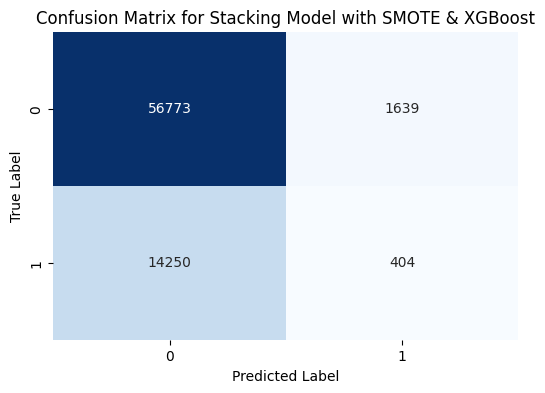

In [ ]:
# Матрица путаницы
conf_matrix = confusion_matrix(y_test, y_pred_stacking_xgb)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Stacking Model with SMOTE & XGBoost')
plt.show()

Оптимизация гиперпараметров XGBoost с использованием RandomizedSearchCV.

In [ ]:
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150]
}

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist,
                                   cv=3, scoring='f1', n_iter=10, random_state=42, n_jobs=-1)

random_search.fit(X_train_smote, y_train_smote)

best_xgb_model = random_search.best_estimator_

y_pred_best_xgb = best_xgb_model.predict(X_test)
y_prob_best_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
f1_best_xgb = f1_score(y_test, y_pred_best_xgb)
roc_auc_best_xgb = roc_auc_score(y_test, y_prob_best_xgb)
precision_best_xgb = precision_score(y_test, y_pred_best_xgb)
recall_best_xgb = recall_score(y_test, y_pred_best_xgb)

print("Accuracy (XGBoost):", accuracy_best_xgb)
print("F1 Score (XGBoost):", f1_best_xgb)
print("Precision (XGBoost):", precision_best_xgb)
print("Recall (XGBoost):", recall_best_xgb)
print("AUC-ROC (XGBoost):", roc_auc_best_xgb)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:03:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (XGBoost): 0.7984561902937071
F1 Score (XGBoost): 0.0016271186440677966
Precision (XGBoost): 0.125
Recall (XGBoost): 0.0008188890405350075
AUC-ROC (XGBoost): 0.49549331870545926


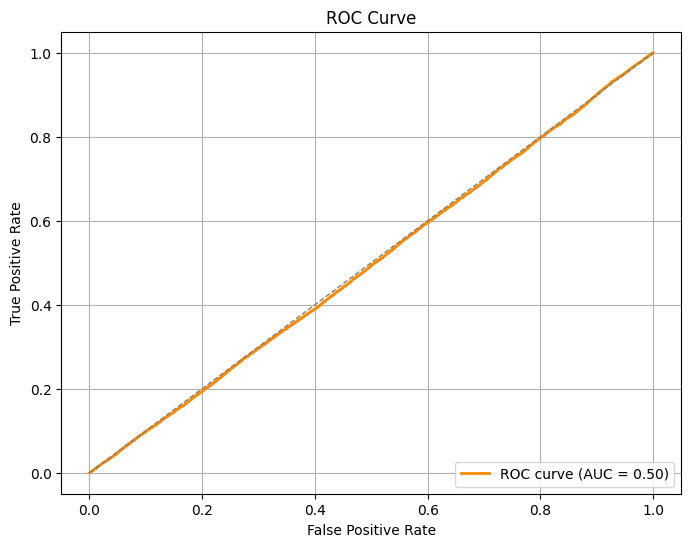

In [ ]:
# построим roc-кривую
fpr_stacking_4, tpr_stacking_4, _ = roc_curve(y_test, y_prob_best_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr_stacking_4, tpr_stacking_4, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_best_xgb))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

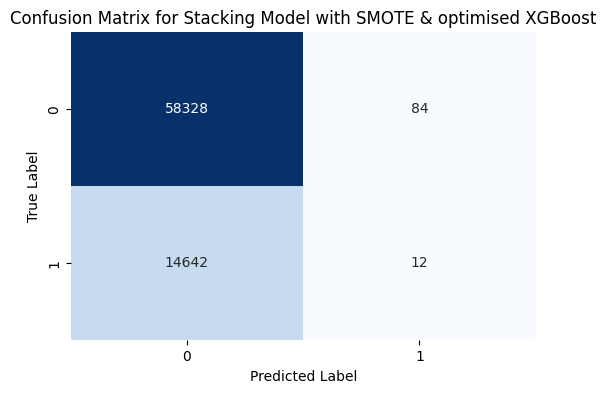

In [ ]:
# Матрица путаницы
conf_matrix = confusion_matrix(y_test, y_pred_best_xgb)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Stacking Model with SMOTE & optimised XGBoost')
plt.show()

Лучшие параметры:

In [ ]:
random_search.best_params_

{'subsample': 0.8,
 'n_estimators': 150,
 'max_depth': 7,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'colsample_bytree': 0.6}

ADASYN (Adaptive Synthetic Sampling) — это метод создания синтетических данных, который адаптируется к данным и фокусируется на труднодоступных для классификации областях.

Также используем лучшие подобранные параметры для XGBoost.

In [ ]:
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

xgb_model_optimized = XGBClassifier(
    subsample=0.8,
    n_estimators=150,
    max_depth=7,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=0.6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model_optimized.fit(X_train_adasyn, y_train_adasyn)

y_pred_xgb_adasyn = xgb_model_optimized.predict(X_test)
y_prob_xgb_adasyn = xgb_model_optimized.predict_proba(X_test)[:, 1]

accuracy_xgb_adasyn = accuracy_score(y_test, y_pred_xgb_adasyn)
f1_xgb_adasyn = f1_score(y_test, y_pred_xgb_adasyn)
roc_auc_xgb_adasyn = roc_auc_score(y_test, y_prob_xgb_adasyn)
precision_xgb_adasyn = precision_score(y_test, y_pred_xgb_adasyn)
recall_xgb_adasyn = recall_score(y_test, y_pred_xgb_adasyn)

print("Accuracy (ADASYN + Optimized XGBoost):", accuracy_xgb_adasyn)
print("F1 Score (ADASYN + Optimized XGBoost):", f1_xgb_adasyn)
print("Precision (ADASYN + Optimized XGBoost):", precision_xgb_adasyn)
print("Recall (ADASYN + Optimized XGBoost):", recall_xgb_adasyn)
print("AUC-ROC (ADASYN + Optimized XGBoost):", roc_auc_xgb_adasyn)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:09:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (ADASYN + Optimized XGBoost): 0.7987846604439821
F1 Score (ADASYN + Optimized XGBoost): 0.0014941591958706874
Precision (ADASYN + Optimized XGBoost): 0.15714285714285714
Recall (ADASYN + Optimized XGBoost): 0.0007506482871570902
AUC-ROC (ADASYN + Optimized XGBoost): 0.495488289904478


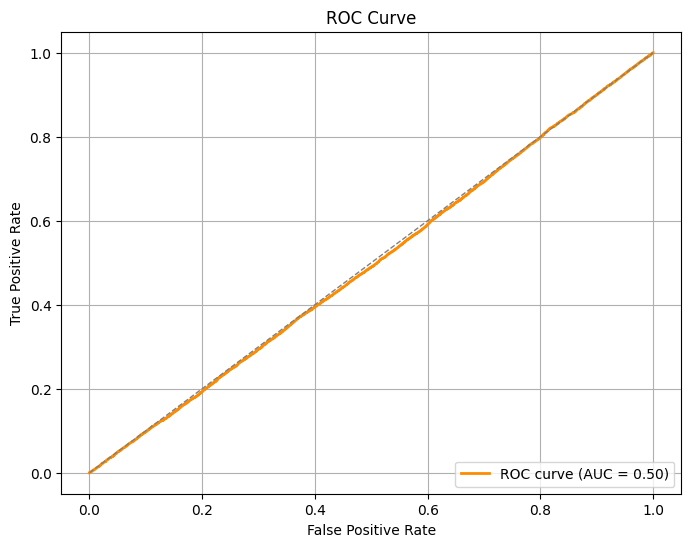

In [ ]:
# построим roc-кривую
fpr_stacking_5, tpr_stacking_5, _ = roc_curve(y_test, y_prob_xgb_adasyn)
plt.figure(figsize=(8, 6))
plt.plot(fpr_stacking_5, tpr_stacking_5, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_xgb_adasyn))
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

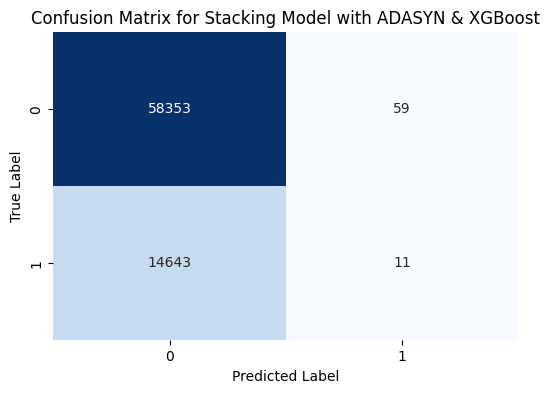

In [ ]:
# Матрица путаницы
conf_matrix = confusion_matrix(y_test, y_pred_xgb_adasyn)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Stacking Model with ADASYN & XGBoost')
plt.show()